
本程式碼請搭配文章「[在 Colab 上利用 Yolov3 框架和自有標住資料來訓練自己的物件辨識系統](http://bit.ly/2OAfpq0)」 一起服用。

其實原意是利用圖片辨識手遊的畫面，來幫我自動玩手遊練功。在找資料的時候，很多人都推薦 Yolov3，優點是非常快速，剛好利用在畫面變動巨大的手遊上。但使用遊戲畫面，可能只有我自己看得懂。所以這篇文章我用最普遍的貓和狗當作範例。能訓練貓和狗就能訓練自己其他的資料了。

# 這篇文章會教你
在此範例中，我們將會訓練一個能偵測圖片中貓和狗的模型。你可以自由替換資料集，偵測自訂的物體。

除此之外，還有：
* 利用 Colab 128G RAM GPU 來訓練你的 Yolo3 模型
* 掛載 Google Drive 檔案到 Colab 檔案系統中
* 將 PASCAL VOC 標籤格式轉換成 Yolo 用的標籤格式
* 產生 Yolo 訓練需要的 cfg 設定檔案
* 將訓練後的 weight 檔案同步至 Google Drive 中，避免遺失
* 如何利用 weight 檔案來辨識圖片中的內容

# 事前準備

在開始前，你需要先編譯好 Darknet 執行檔案。你可以參考我的另外一篇文章「[如何在 Colab 安裝 Darknet 框架訓練 YOLO v3 物件辨識並且最佳化 Colab 的訓練流程](http://bit.ly/33XjcEu)」，文章中會將編譯好的 Darknet 執行檔案放到 Google Drive目錄下。本文章將會利用這個執行檔案進行訓練。




---




## 將 Google Drive 掛載到 Colab 目錄下

掛載 Google Drive 的好處是不用每次都手動上傳或下載檔案，而且還能讓訓練好的模型檔案自動保存到 Google Drive。這樣就不會因為 Colab 中斷後就必須從頭訓練。

In [0]:
# 將 Google Drive 掛載到 Colab 目錄下
from google.colab import drive
drive.mount('/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


# 準備資料集

您可以使用自己的資料夾。為了示範，這邊使用 [The Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) 已經標注好的寵物資料來當作範例。我們會用到裡面的圖片檔以及 `annotations` 中的 `xml` 標註資料。

In [0]:
%cd /content

# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

# 如果你已經把檔案下載到你的 Google Drive 就可以直接用複製的，速度會快一些
# !cp /drive/My\ Drive/ColabDrive/The_Oxford_IIIT_Pet_Dataset/images.tar.gz /content/
# !cp /drive/My\ Drive/ColabDrive/The_Oxford_IIIT_Pet_Dataset/annotations.tar.gz /content/

# move image and label folder into pet_detection folder
# !mkdir /content/pet_detection
# !tar -xf images.tar.gz -C /content/pet_detection
# !tar -xf annotations.tar.gz
# !mv annotations/xmls /content/pet_detection/labels
# !rm -fr annotations

/content


## 定義後來會用到的檔案路徑

路徑分為保存在 Colab 的，每次 Colab 被重置後就會消失。所以只放一些不重要的東西。
保存在 Google Drive 的檔案就是會被保存下來的，即使 Colab 被重置後，也不會消失；我們會把重要的東西存在這，例如設定檔、訓練到一半的模型等。

In [0]:
# define constants

#LOCAL_IMAGES_DIR_PATH = "/content/pet_detection/images"
#LOCAL_LABELS_DIR_PATH = "/content/pet_detection/labels"

LOCAL_IMAGES_DIR_PATH = "/drive/My Drive/Final_Project/data/images"
LOCAL_LABELS_DIR_PATH = "/drive/My Drive/Final_Project/data/labels"
LOCAL_YOLOS_DIR_PATH = "/content/pet_detection/yolos"
LOCAL_CFG_DIR_PATH = "/content/pet_detection/cfg"
GDRIVE_APP_BASE_DIR_REMOTE_PATH = "/drive/My\ Drive/train_yolo_with_custom_dataset_on_colab_101"

GDRIVE_APP_BASE_DIR_PATH = "/content/app"
GDRIVE_WEIGHTS_DIR_PATH = GDRIVE_APP_BASE_DIR_PATH+"/weights"
GDRIVE_CFG_DIR_PATH = GDRIVE_APP_BASE_DIR_PATH+"/cfg"
GITHUB_CODEBASE_DIR_PATH = "/content/train_yolo_with_custom_dataset_on_colab_101"

GDRIVE_DARKNET_BIN_FILE_PATH = GITHUB_CODEBASE_DIR_PATH+"/darknet"


In [0]:
# load sample codes
%cd /content
!git clone https://github.com/wallat/train_yolo_with_custom_dataset_on_colab_101.git



/content
Cloning into 'train_yolo_with_custom_dataset_on_colab_101'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 23 (delta 4), reused 19 (delta 3), pack-reused 0
Unpacking objects: 100% (23/23), done.


In [0]:
# build the link to avoiding type in long path name everytime
!ln -fs {GDRIVE_APP_BASE_DIR_REMOTE_PATH} {GDRIVE_APP_BASE_DIR_PATH}

In [0]:
# clean folders

import os
import shutil

shutil.rmtree(LOCAL_CFG_DIR_PATH, ignore_errors=True)
shutil.rmtree(LOCAL_YOLOS_DIR_PATH, ignore_errors=True)

os.makedirs(GDRIVE_APP_BASE_DIR_REMOTE_PATH.replace("\ ", " "), exist_ok=True)
os.makedirs(GDRIVE_CFG_DIR_PATH, exist_ok=True)
os.makedirs(GDRIVE_WEIGHTS_DIR_PATH, exist_ok=True)

os.makedirs(LOCAL_CFG_DIR_PATH, exist_ok=True)
os.makedirs(LOCAL_YOLOS_DIR_PATH, exist_ok=True)
# os.makedirs(GDRIVE_CFG_DIR_PATH, exist_ok=True)



## 擷取出所有的標籤名稱

由於 darknet 框架會將物體名字全部轉成數字，我們需要先將物體名字全部擷取出來存在一份檔案中，當作之後的對照表。

In [0]:
# Convert VOC xmls into Yolo's format

import glob
import os
import re

labels = set()
for path in glob.glob(os.path.join(LOCAL_LABELS_DIR_PATH, "*.xml")):
    with open(path, 'r') as f:
        content = f.read()

    # extract label names
    matches = re.findall(r'<name>([\w_]+)<\/name>', content, flags=0)
    labels.update(matches)

# write label into file`
with open(os.path.join(GDRIVE_CFG_DIR_PATH, "obj.names"), 'w') as f:
    f.write("\n".join(labels))

print('Read in %d labels: %s' % (len(labels), ", ".join(labels)))

Read in 2 labels: kangaroo, raccoon


## 將 VOC 格式的標記資料轉成 YOLO 的標記資料

Yolo 不是使用標準的格式，原本的 VOC 標記格式需要轉換後才能使用在 darkent 框架上。
這邊就不詳細解釋如何轉換，對如何轉換的詳細規格可以參考 Yolo 官網 。我們直接使用我從 convert2Yolo 套件中擷取出來的片段程式碼來執行轉換，並把轉換的結果都放到 `/content/pet_detection/yolos` 目錄中。

In [0]:
import sys
sys.path.append(GITHUB_CODEBASE_DIR_PATH)

from Format import VOC, YOLO

voc = VOC()
yolo = YOLO(os.path.join(GDRIVE_CFG_DIR_PATH, "obj.names"))

flag, data = voc.parse(LOCAL_LABELS_DIR_PATH)
flag, data = yolo.generate(data)

flag, data = yolo.save(data,
    save_path=LOCAL_YOLOS_DIR_PATH,
    img_path=LOCAL_IMAGES_DIR_PATH, img_type=".jpg", manipast_path="./")

l ['kangaroo', 'raccoon']

VOC Parsing:   |████████████████████████████████████████| 100.0% (364/364)  Complete


YOLO Generating:|████████████████████████████████████████| 100.0% (364/364)  Complete


YOLO Saving:   |████████████████████████████████████████| 100.0% (364/364)  Complete



In [0]:
LOCAL_IMAGES_DIR_PATH = "/drive/My\ Drive/Final_Project/data/images"
LOCAL_LABELS_DIR_PATH = "/drive/My\ Drive/Final_Project/data/labels"

In [0]:
# copy images into yolos folder
# !find $LOCAL_IMAGES_DIR_PATH -name "*.jpg" -exec cp {} /content/pet_detection/yolos \;

# from distutils.dir_util import copy_tree
# copy_tree(LOCAL_IMAGES_DIR_PATH, LOCAL_YOLOS_DIR_PATH)

!cp {LOCAL_IMAGES_DIR_PATH}/*.jpg {LOCAL_YOLOS_DIR_PATH}

## 準備訓練用的設定檔

* `obj.names`：所有的物體標籤名稱，每一行一個。例如此例中只會有兩行，分別是 cat dog 。
* `yolov3.cfg`：darknet 網路的設定檔，描述每一層網路應該要如何建立，以及建立多少 node 等。裡面有些數值需要根據你的訓練資料來個別設定。
* `train.txt` `test.txt` ：這兩個檔案告訴 darknet 要到哪個路徑下找到訓練用的圖片。
* `obj.data`：darknet 的主要設定檔案，告訴 darknet 其他的設定檔路徑。darknet 會一一去讀取其他的檔案。

In [0]:
# create the cfg file
!cp {GITHUB_CODEBASE_DIR_PATH}/darknet_cfg/yolov3.cfg {GDRIVE_CFG_DIR_PATH}/yolov3.cfg

# fetch label_names
with open(os.path.join(GDRIVE_CFG_DIR_PATH, "obj.names"), 'r') as f:
  f_content = f.read()
label_names = f_content.strip().splitlines()

# update the cfg file
with open(os.path.join(GDRIVE_CFG_DIR_PATH, "yolov3.cfg"), 'r') as f:
  content = f.read()
with open(os.path.join(GDRIVE_CFG_DIR_PATH, "yolov3.cfg"), 'w') as f:
  num_max_batches = len(label_names)*2000
  content = content.replace("%NUM_CLASSES%", str(len(label_names)))
  content = content.replace("%NUM_MAX_BATCHES%", str(num_max_batches))
  content = content.replace("%NUM_MAX_BATCHES_80%", str(int(num_max_batches*0.8)))
  content = content.replace("%NUM_MAX_BATCHES_90%", str(int(num_max_batches*0.9)))
  content = content.replace("%NUM_CONVOLUTIONAL_FILTERS%", str((len(label_names)+5)*3))

  f.write(content)

In [0]:
# create train and test files
import random
import glob

txt_paths = glob.glob(os.path.join(LOCAL_YOLOS_DIR_PATH, "*.txt"))

random.shuffle(txt_paths)
num_train_images = int(len(txt_paths)*0.8)

assert num_train_images>0, "There's no training images in folder %s" % (LOCAL_YOLOS_DIR_PATH)

with open(os.path.join(GDRIVE_CFG_DIR_PATH, "train.txt"), 'w') as f:
  for path in txt_paths[:num_train_images]:
    f.write("%s/%s\n" % (LOCAL_YOLOS_DIR_PATH, os.path.basename(path).replace(".txt", ".jpg")))
with open(os.path.join(GDRIVE_CFG_DIR_PATH, "test.txt"), 'w') as f:
  for path in txt_paths[num_train_images:]:
    f.write("%s/%s\n" % (LOCAL_YOLOS_DIR_PATH, os.path.basename(path).replace(".txt", ".jpg")))

# create obj
with open(os.path.join(GDRIVE_CFG_DIR_PATH, "obj.data"), 'w') as f:
  f.write("classes=%d\n" % (len(label_names)))
  f.write("train=%s/train.txt\n" % (GDRIVE_CFG_DIR_PATH))
  f.write("valid=%s/test.txt\n" % (GDRIVE_CFG_DIR_PATH))
  f.write("names=%s/obj.names\n" % (GDRIVE_CFG_DIR_PATH))
  f.write("backup=%s\n" % (GDRIVE_WEIGHTS_DIR_PATH))

## 準備 darkent 執行檔

我們直接從之前已經編譯好的檔案複製過來就好，不用每次都重頭編譯那實在是太~花~時~間~了~。編譯的方法請見 「[如何在 Colab 安裝 Darknet 框架訓練 YOLO v3 物件辨識並且最佳化 Colab 的訓練流程](http://bit.ly/33XjcEu)」這邊文章。

In [0]:
# copy the pretrained darknet bin file
!cp {GDRIVE_DARKNET_BIN_FILE_PATH} /content/
assert os.path.isfile("/content/darknet"), 'Cannot copy from %s to /content' % (GDRIVE_DARKNET_BIN_FILE_PATH)

!chmod +x /content/darknet

## （可選）使用 darknet 預先訓練的基底模型

Darknet 也好心的提供了預先訓練的模型，以此為基底，可以讓後來的訓練比較快達到較好的辨識率。但前提是你的圖片都是常見的圖片，例如一般照片、場景照片等；如果是一些遊戲畫面很少見的，從 0 開始訓練可能會達到比較好的效果。

In [0]:
# Use the pre-trained weights to speed up the training speed
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2020-03-07 10:31:21--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M   342KB/s    in 7m 1s   

2020-03-07 10:38:24 (377 KB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



# 終於可以開始訓練模型了～

上面的步驟看起來很多，但其實只要寫好一次，之後每次訓練時只要換上自己要的資料夾，然後按 `Run all` 就可以了。

這邊提供兩條指令：

1. 是從 YOLO Pre-trained model 開始訓練，如果你的資料集是一般照片，那用這個效果會比較好。

2. 是從上次訓練的中斷點繼續往下訓練；指令會讀取資料夾內的 weight 檔案，從上次中斷點繼續訓練下去。適合從 0 開始訓練或是被 Colab 中斷後重新開始訓練。

In [0]:
# train the model

# !./darknet detector train {GDRIVE_CFG_DIR_PATH}/obj.data {GDRIVE_CFG_DIR_PATH}/yolov3.cfg darknet53.conv.74 -dont_show
# !./darknet detector train {GDRIVE_CFG_DIR_PATH}/obj.data {GDRIVE_CFG_DIR_PATH}/yolov3.cfg darknet53.conv.74  -dont_show | grep "avg loss"
!./darknet detector train {GDRIVE_CFG_DIR_PATH}/obj.data {GDRIVE_CFG_DIR_PATH}/yolov3.cfg {GDRIVE_WEIGHTS_DIR_PATH}/yolov3_last.weights  -dont_show | grep "avg loss"



layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  14 c

# 檢視訓練成果

檢測圖片時，我們只需要 `obj.names`, `yolov3.cfg` 以及 weights 檔就夠。我們可以直接利用 Opencv 內建的 darknet 來讀取網路並產生出預測。

In [0]:
GITHUB_CODEBASE_DIR_PATH = "/content/train_yolo_with_custom_dataset_on_colab_101"

fpath /content/train_yolo_with_custom_dataset_on_colab_101/to_detect_images/raccoon-89.jpg


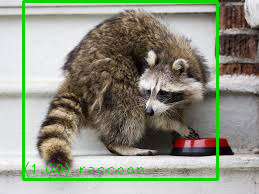

fpath /content/train_yolo_with_custom_dataset_on_colab_101/to_detect_images/00012.jpg


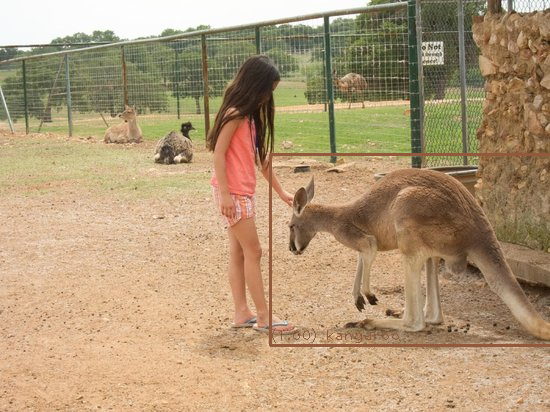

fpath /content/train_yolo_with_custom_dataset_on_colab_101/to_detect_images/raccoon-135.jpg


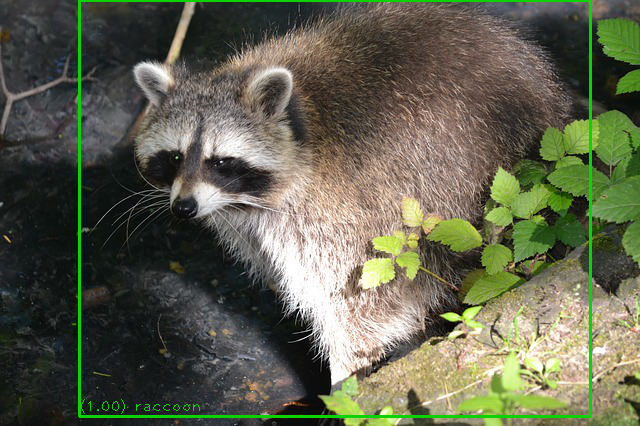

fpath /content/train_yolo_with_custom_dataset_on_colab_101/to_detect_images/00178.jpg


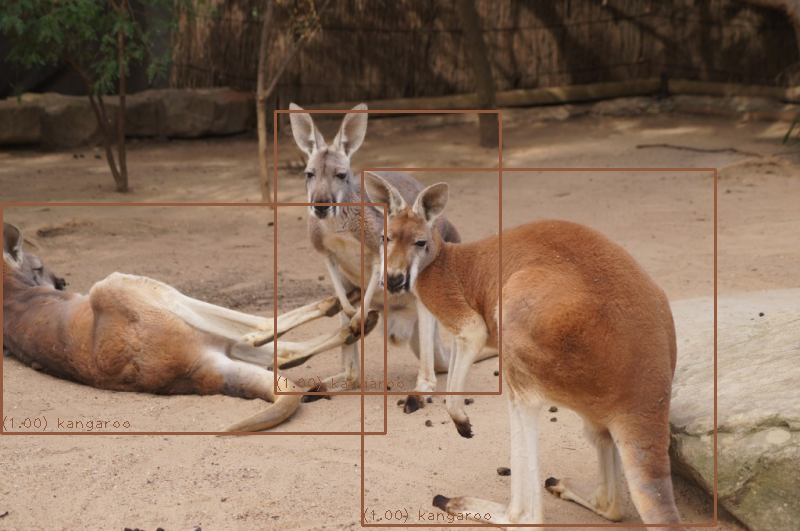

fpath /content/train_yolo_with_custom_dataset_on_colab_101/to_detect_images/00171.jpg


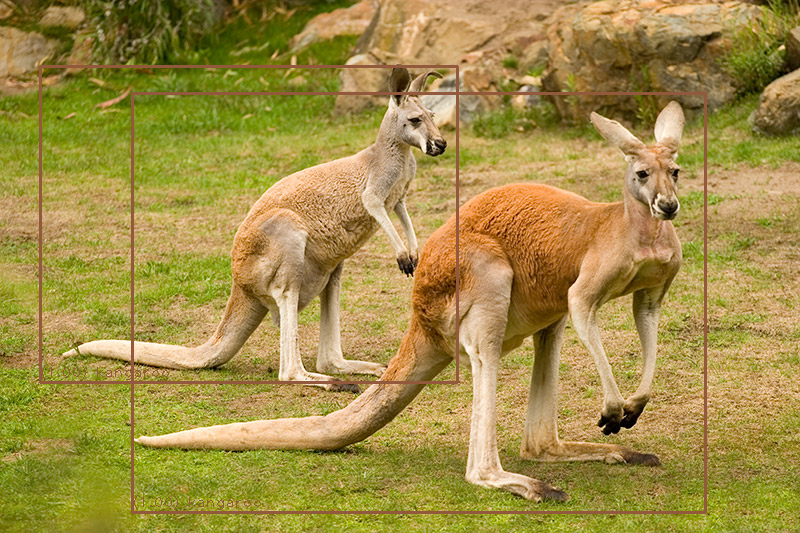

fpath /content/train_yolo_with_custom_dataset_on_colab_101/to_detect_images/00182.jpg


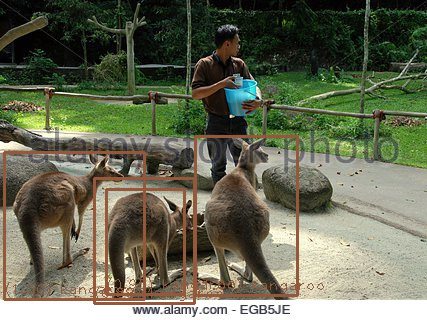

fpath /content/train_yolo_with_custom_dataset_on_colab_101/to_detect_images/raccoon-132.jpg


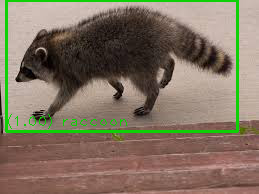

fpath /content/train_yolo_with_custom_dataset_on_colab_101/to_detect_images/raccoon-140.jpg


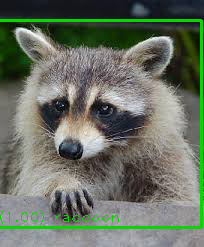

In [38]:
TO_DETECTING_IMAGE_DIR_PATH = GITHUB_CODEBASE_DIR_PATH+"/to_detect_images"

# Use python to read 

import os
import cv2
import numpy as np
import glob
from google.colab.patches import cv2_imshow

import pprint
pp = pprint.PrettyPrinter(indent=4)


def detecting_one_image(net, output_layers, img):
  # Detecting objects
  # cv::dnn::blobFromImage (InputArray image, double scalefactor=1.0, const Size &size=Size(), const Scalar &mean=Scalar(), bool swapRB=false, bool crop=false, int ddepth=CV_32F)
  blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
  net.setInput(blob)
  outs = net.forward(output_layers)

  return outs

# Load Yolo
net = cv2.dnn.readNet(GDRIVE_WEIGHTS_DIR_PATH+"/yolov3_last.weights", GDRIVE_CFG_DIR_PATH+"/yolov3.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Load label names
with open(GDRIVE_CFG_DIR_PATH+"/obj.names", "r") as f:
  classes = [line.strip() for line in f.readlines()]

# Generate display colors
colors = np.random.uniform(0, 255, size=(len(classes), 3))

for fpath in glob.glob(os.path.join(TO_DETECTING_IMAGE_DIR_PATH, "*.jpg")):
  print("fpath", fpath)

  # Loading image
  img = cv2.imread(fpath)
  height, width, channels = img.shape

  if width>800: # resize for display purpose
    dim = (800, int(800*height/width))
    img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    height, width, channels = img.shape

  outs = detecting_one_image(net, output_layers, img)

  # Showing informations on the screen
  for out in outs:
    for detection in out:
      scores = detection[5:]
      class_id = np.argmax(scores)
      confidence = scores[class_id]
      if confidence > 0.3:
        # Object detected
        center_x = int(detection[0] * width)
        center_y = int(detection[1] * height)
        w = int(detection[2] * width)
        h = int(detection[3] * height)

        # Rectangle coordinates
        x = int(center_x - w / 2)
        y = int(center_y - h / 2)

        label = "(%.2f) %s" % (confidence, classes[class_id])

        cv2.rectangle(img, (x, y), (x + w, y + h), colors[class_id], 2)
        cv2.putText(img, label, (x, y+h-5), cv2.FONT_HERSHEY_PLAIN, 1, colors[class_id], 1)

  cv2_imshow(img)